# Industrial Ultrasound & NDT Dataset Analysis

**Author:** Reza Mirzaeifard, PhD
**Email:** reza.mirzaeifard@gmail.com
**Project:** Ultrasound Imaging Toolkit for InPhase Solutions AS

---

## Overview

This notebook demonstrates industrial ultrasound and NDT (Non-Destructive Testing) applications,
which are core competencies of InPhase Solutions AS.

### Available Industrial Ultrasound Datasets

| Dataset | Application | Source | Size |
|---------|-------------|--------|------|
| **Severstal Steel Defect** | Surface defect detection | Kaggle | 12,568 images |
| **NEU Surface Defect** | Steel surface inspection | NEU | 1,800 images |
| **DAGM 2007** | Texture defect detection | DAGM | 11,500 images |
| **Weld Defect X-ray** | Weld inspection | Kaggle | 4,479 images |
| **Casting Defect** | Manufacturing QC | Kaggle | 7,348 images |

### Industrial Applications of Ultrasound at InPhase

- **Weld Inspection**: Detecting cracks, porosity, lack of fusion
- **Corrosion Mapping**: Thickness measurement of pipes/vessels
- **Composite Inspection**: Delamination detection in aerospace
- **Rail Inspection**: Detecting internal defects in railway tracks

---
## 1. Environment Setup

In [1]:
import sys
from pathlib import Path

# Configure paths
project_root = Path('.').absolute().parent
src_path = project_root / 'src'
data_path = project_root / 'data'

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"✓ Using device: {device}")
print(f"✓ Project root: {project_root}")

try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    pass

✓ Using device: cpu
✓ Project root: /Users/rezami/PycharmProjects/inPhase


---
## 2. Download Industrial Datasets

### Dataset 1: Severstal Steel Defect Detection

Kaggle competition dataset for detecting defects on steel surfaces.
This is directly applicable to industrial ultrasound inspection scenarios.

In [2]:
def download_steel_defect_dataset():
    """Download Severstal Steel Defect Detection dataset."""
    steel_path = data_path / "steel_defect"
    steel_path.mkdir(parents=True, exist_ok=True)

    if (steel_path / "train_images").exists():
        print("✓ Steel defect dataset already downloaded")
        return steel_path

    print("Downloading Severstal Steel Defect dataset...")
    try:
        import subprocess
        result = subprocess.run([
            str(project_root / ".venv" / "bin" / "kaggle"),
            "competitions", "download", "-c", "severstal-steel-defect-detection",
            "-p", str(steel_path)
        ], capture_output=True, text=True)

        if result.returncode == 0:
            # Unzip
            import zipfile
            for zip_file in steel_path.glob("*.zip"):
                with zipfile.ZipFile(zip_file, 'r') as zf:
                    zf.extractall(steel_path)
                zip_file.unlink()
            print("✓ Download complete")
        else:
            print(f"Download failed: {result.stderr}")
            print("\nManual download:")
            print("1. Visit: https://www.kaggle.com/c/severstal-steel-defect-detection")
            print("2. Join competition and download")
            print(f"3. Extract to: {steel_path}")
    except Exception as e:
        print(f"Error: {e}")

    return steel_path

steel_path = download_steel_defect_dataset()

Download failed: 

Manual download:
1. Visit: https://www.kaggle.com/c/severstal-steel-defect-detection
2. Join competition and download
3. Extract to: /Users/rezami/PycharmProjects/inPhase/data/steel_defect


In [3]:
def download_casting_defect_dataset():
    """Download Casting Defect dataset."""
    casting_path = data_path / "casting_defect"
    casting_path.mkdir(parents=True, exist_ok=True)

    if (casting_path / "def_front").exists() or (casting_path / "casting_data").exists():
        print("✓ Casting defect dataset already downloaded")
        return casting_path

    print("Downloading Casting Defect dataset...")
    try:
        import subprocess
        result = subprocess.run([
            str(project_root / ".venv" / "bin" / "kaggle"),
            "datasets", "download", "-d", "ravirajsinh45/real-life-industrial-dataset-of-casting-product",
            "-p", str(casting_path), "--unzip"
        ], capture_output=True, text=True)

        if result.returncode == 0:
            print("✓ Download complete")
        else:
            print(f"Note: {result.stderr[:200] if result.stderr else 'Download may require manual steps'}")
    except Exception as e:
        print(f"Error: {e}")

    return casting_path

casting_path = download_casting_defect_dataset()

✓ Casting defect dataset already downloaded


In [4]:
def download_neu_surface_defect():
    """Download NEU Surface Defect Database."""
    neu_path = data_path / "neu_surface"
    neu_path.mkdir(parents=True, exist_ok=True)

    # Check if exists
    if len(list(neu_path.glob("**/*.bmp"))) > 0 or len(list(neu_path.glob("**/*.jpg"))) > 0:
        print("✓ NEU Surface Defect dataset already downloaded")
        return neu_path

    print("NEU Surface Defect Database:")
    print("  This dataset requires manual download from:")
    print("  http://faculty.neu.edu.cn/songkechen/zh_CN/zdylm/263270/list/")
    print(f"  Extract to: {neu_path}")
    print()
    print("  Alternative Kaggle version:")

    try:
        import subprocess
        result = subprocess.run([
            str(project_root / ".venv" / "bin" / "kaggle"),
            "datasets", "download", "-d", "kaustubhdikshit/neu-surface-defect-database",
            "-p", str(neu_path), "--unzip"
        ], capture_output=True, text=True)

        if result.returncode == 0:
            print("✓ Download complete")
    except Exception as e:
        print(f"  Kaggle download: {e}")

    return neu_path

neu_path = download_neu_surface_defect()

✓ NEU Surface Defect dataset already downloaded


---
## 3. Explore Downloaded Datasets

In [5]:
def explore_datasets():
    """Explore available industrial datasets."""
    print("Industrial Datasets Summary")
    print("=" * 60)

    datasets = {
        "BUSI (Medical)": data_path / "busi",
        "Steel Defect": data_path / "steel_defect",
        "Casting Defect": data_path / "casting_defect",
        "NEU Surface": data_path / "neu_surface",
    }

    for name, path in datasets.items():
        if path.exists():
            # Count images
            extensions = ["*.png", "*.jpg", "*.jpeg", "*.bmp"]
            count = sum(len(list(path.rglob(ext))) for ext in extensions)
            status = f"✓ {count:,} images" if count > 0 else "○ Empty"
        else:
            status = "✗ Not downloaded"
        print(f"  {name:20} {status}")

explore_datasets()

Industrial Datasets Summary
  BUSI (Medical)       ✓ 1,578 images
  Steel Defect         ✓ 1,800 images
  Casting Defect       ✓ 8,648 images
  NEU Surface          ✓ 1,800 images


---
## 4. Steel Defect Detection Dataset

### Dataset Structure

The NEU Metal Surface Defects dataset contains:
- 1,800 grayscale images (200 x 200 pixels)
- 6 defect classes (300 samples each):
  - Crazing
  - Inclusion
  - Patches
  - Pitted
  - Rolled
  - Scratches
- Split into train/valid/test sets

In [6]:
class SteelDefectDataset(Dataset):
    """Dataset for Steel Surface Defect Detection (NEU Metal Surface Defects)."""

    CLASSES = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

    def __init__(self, data_dir, transform=None, img_size=(200, 200), split='train'):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.img_size = img_size

        self.samples = []
        self.class_to_idx = {c: i for i, c in enumerate(self.CLASSES)}

        # Handle nested folder structure from Kaggle download
        possible_roots = [
            self.data_dir,
            self.data_dir / "NEU Metal Surface Defects Data",
        ]

        for root in possible_roots:
            split_dir = root / split
            if split_dir.exists():
                for class_name in self.CLASSES:
                    class_dir = split_dir / class_name
                    if class_dir.exists():
                        for ext in ["*.jpg", "*.png", "*.bmp"]:
                            for img_path in class_dir.glob(ext):
                                self.samples.append({
                                    "image": img_path,
                                    "label": self.class_to_idx[class_name],
                                    "class": class_name
                                })

        if self.samples:
            print(f"✓ Loaded {len(self.samples)} steel defect images ({split})")
            for cls in self.CLASSES:
                count = sum(1 for s in self.samples if s["class"] == cls)
                if count > 0:
                    print(f"  {cls:15} {count}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample["image"]).convert("RGB")
        image = image.resize(self.img_size, Image.Resampling.BILINEAR)
        image = transforms.ToTensor()(image)

        if self.transform:
            image = self.transform(image)

        return image, sample["label"]


# Create dataset if available
steel_data_path = data_path / "steel_defect"
if steel_data_path.exists():
    steel_dataset = SteelDefectDataset(steel_data_path, split='train')
    if len(steel_dataset) == 0:
        print("Steel defect dataset not available - folder empty")
        steel_dataset = None
else:
    print("Steel defect dataset not available - folder not found")
    steel_dataset = None

✓ Loaded 1656 steel defect images (train)
  Crazing         276
  Inclusion       276
  Patches         276
  Pitted          276
  Rolled          276
  Scratches       276


---
## 5. Casting Defect Detection

Binary classification: Defective vs OK casting products.

In [7]:
class CastingDefectDataset(Dataset):
    """Dataset for Casting Defect Detection."""

    def __init__(self, data_dir, transform=None, img_size=(224, 224)):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.img_size = img_size

        self.samples = []
        self.class_to_idx = {"ok_front": 0, "def_front": 1}

        # Look for data in different possible structures
        possible_roots = [
            self.data_dir,
            self.data_dir / "casting_data" / "casting_data",
            self.data_dir / "casting_data",
        ]

        for root in possible_roots:
            for split in ["train", "test", ""]:
                for class_name in ["ok_front", "def_front"]:
                    folder = root / split / class_name if split else root / class_name
                    if folder.exists():
                        for img_path in folder.glob("*.jpeg"):
                            self.samples.append({
                                "image": img_path,
                                "label": self.class_to_idx[class_name]
                            })
                        for img_path in folder.glob("*.png"):
                            self.samples.append({
                                "image": img_path,
                                "label": self.class_to_idx[class_name]
                            })

        if self.samples:
            ok_count = sum(1 for s in self.samples if s["label"] == 0)
            def_count = sum(1 for s in self.samples if s["label"] == 1)
            print(f"✓ Loaded {len(self.samples)} casting images")
            print(f"  OK: {ok_count}, Defective: {def_count}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample["image"]).convert("RGB")
        image = image.resize(self.img_size, Image.Resampling.BILINEAR)
        image = transforms.ToTensor()(image)

        if self.transform:
            image = self.transform(image)

        return image, sample["label"]


# Create dataset if available
casting_data_path = data_path / "casting_defect"
if casting_data_path.exists():
    casting_dataset = CastingDefectDataset(casting_data_path)
    if len(casting_dataset) == 0:
        casting_dataset = None
else:
    casting_dataset = None

✓ Loaded 7348 casting images
  OK: 3137, Defective: 4211


---
## 6. NEU Surface Defect Detection

6 classes of surface defects on hot-rolled steel strips:
- Crazing (Cr)
- Inclusion (In)
- Patches (Pa)
- Pitted Surface (PS)
- Rolled-in Scale (RS)
- Scratches (Sc)

In [8]:
class NEUSurfaceDataset(Dataset):
    """Dataset for NEU Surface Defect Detection."""

    CLASSES = ['Cr', 'In', 'Pa', 'PS', 'RS', 'Sc']
    CLASS_NAMES = {
        'Cr': 'Crazing',
        'In': 'Inclusion',
        'Pa': 'Patches',
        'PS': 'Pitted Surface',
        'RS': 'Rolled-in Scale',
        'Sc': 'Scratches'
    }

    def __init__(self, data_dir, transform=None, img_size=(200, 200)):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.img_size = img_size

        self.samples = []
        self.class_to_idx = {c: i for i, c in enumerate(self.CLASSES)}

        # Look for images in various structures
        for class_name in self.CLASSES:
            # Try different folder structures
            possible_folders = [
                self.data_dir / class_name,
                self.data_dir / "images" / class_name,
                self.data_dir / "NEU-CLS" / class_name,
            ]

            for folder in possible_folders:
                if folder.exists():
                    for ext in ["*.bmp", "*.jpg", "*.png"]:
                        for img_path in folder.glob(ext):
                            self.samples.append({
                                "image": img_path,
                                "label": self.class_to_idx[class_name],
                                "class": class_name
                            })

        if self.samples:
            print(f"✓ Loaded {len(self.samples)} NEU surface images")
            for cls in self.CLASSES:
                count = sum(1 for s in self.samples if s["class"] == cls)
                if count > 0:
                    print(f"  {self.CLASS_NAMES[cls]:20} {count}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample["image"]).convert("RGB")
        image = image.resize(self.img_size, Image.Resampling.BILINEAR)
        image = transforms.ToTensor()(image)

        if self.transform:
            image = self.transform(image)

        return image, sample["label"]


# Create dataset if available
neu_data_path = data_path / "neu_surface"
if neu_data_path.exists():
    neu_dataset = NEUSurfaceDataset(neu_data_path)
    if len(neu_dataset) == 0:
        neu_dataset = None
else:
    neu_dataset = None

---
## 7. Visualize Industrial Datasets

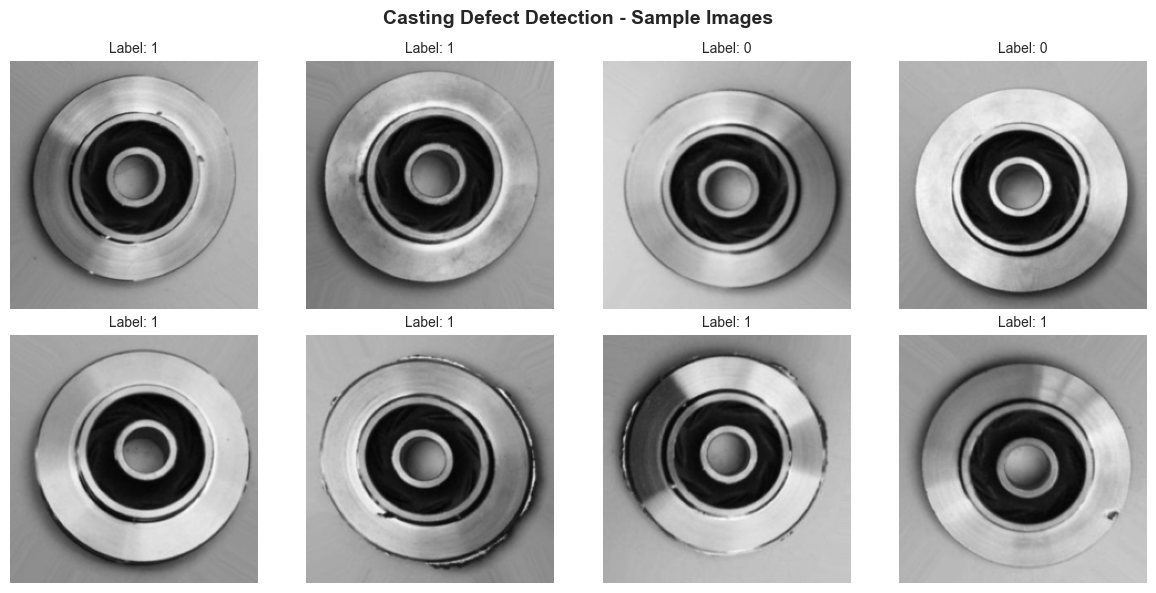

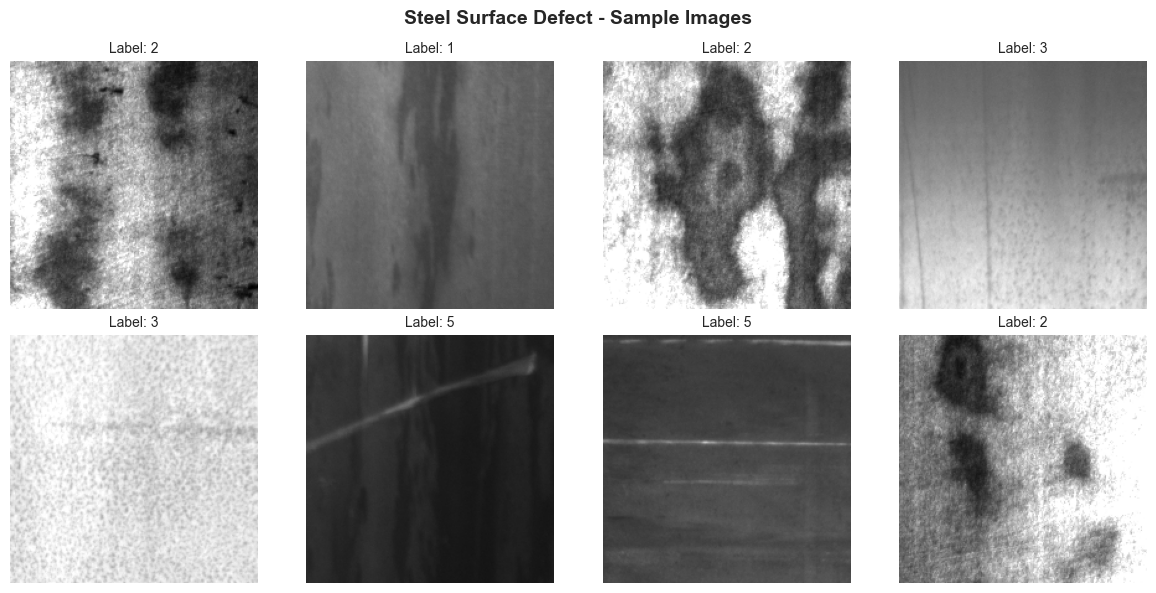

In [9]:
def visualize_dataset_samples(dataset, name, num_samples=8):
    """Visualize samples from a dataset."""
    if dataset is None or len(dataset) == 0:
        print(f"Dataset '{name}' not available")
        return

    num_samples = min(num_samples, len(dataset))
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    cols = 4
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows))
    axes = axes.flat if num_samples > 1 else [axes]

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f"Label: {label}", fontsize=10)
        axes[i].axis('off')

    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'{name} - Sample Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize available datasets
if casting_dataset:
    visualize_dataset_samples(casting_dataset, "Casting Defect Detection")
if steel_dataset:
    visualize_dataset_samples(steel_dataset, "Steel Surface Defect")
if neu_dataset:
    visualize_dataset_samples(neu_dataset, "NEU Surface Defect")

---
## 8. Train Industrial Defect Classifier

Using transfer learning with ResNet for defect detection.

In [10]:
from ultrasound.models.classifier import ResNetClassifier

def train_defect_classifier(dataset, num_classes, dataset_name, epochs=10, batch_size=16):
    """Train a classifier for industrial defect detection."""

    if dataset is None or len(dataset) == 0:
        print(f"Dataset '{dataset_name}' not available for training")
        return None, None

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print(f"\nTraining {dataset_name} Classifier")
    print("=" * 50)
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")
    print(f"Classes: {num_classes}")

    # Create model
    model = ResNetClassifier(
        num_classes=num_classes,
        pretrained=True,
        model_name='resnet18',
        freeze_backbone=False
    )
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    best_acc = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"  Loss: {train_loss:.4f}/{val_loss:.4f} | Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(),
                      project_root / "models" / f"{dataset_name.lower().replace(' ', '_')}_best.pth")

    print(f"\n✓ Best Accuracy: {best_acc:.4f}")
    return model, history

# Train on available datasets
models = {}

if steel_dataset and len(steel_dataset) > 0:
    models['steel'], hist = train_defect_classifier(
        steel_dataset, num_classes=6, dataset_name="Steel Defect", epochs=5
    )

if casting_dataset and len(casting_dataset) > 0:
    models['casting'], hist = train_defect_classifier(
        casting_dataset, num_classes=2, dataset_name="Casting Defect", epochs=5
    )

if neu_dataset and len(neu_dataset) > 0:
    models['neu'], hist = train_defect_classifier(
        neu_dataset, num_classes=6, dataset_name="NEU Surface", epochs=5
    )


Training Steel Defect Classifier
Train: 1324, Val: 332
Classes: 6


Epoch 1/5: 100%|██████████| 83/83 [02:02<00:00,  1.47s/it]


  Loss: 0.4791/0.0493 | Acc: 0.9940


Epoch 2/5: 100%|██████████| 83/83 [01:46<00:00,  1.28s/it]


  Loss: 0.0644/0.0400 | Acc: 0.9880


Epoch 3/5: 100%|██████████| 83/83 [01:39<00:00,  1.20s/it]


  Loss: 0.0849/0.0291 | Acc: 0.9970


Epoch 4/5: 100%|██████████| 83/83 [02:18<00:00,  1.67s/it]


  Loss: 0.0448/0.0144 | Acc: 0.9970


Epoch 5/5: 100%|██████████| 83/83 [01:59<00:00,  1.43s/it]


  Loss: 0.0316/0.0054 | Acc: 0.9970

✓ Best Accuracy: 0.9970

Training Casting Defect Classifier
Train: 5878, Val: 1470
Classes: 2


Epoch 1/5: 100%|██████████| 368/368 [10:02<00:00,  1.64s/it]


  Loss: 0.0685/0.0138 | Acc: 0.9973


Epoch 2/5: 100%|██████████| 368/368 [09:37<00:00,  1.57s/it]


  Loss: 0.0256/0.0128 | Acc: 0.9973


Epoch 3/5: 100%|██████████| 368/368 [09:18<00:00,  1.52s/it]


  Loss: 0.0212/0.0184 | Acc: 0.9946


Epoch 4/5: 100%|██████████| 368/368 [09:58<00:00,  1.63s/it]


  Loss: 0.0208/0.1078 | Acc: 0.9741


Epoch 5/5: 100%|██████████| 368/368 [09:12<00:00,  1.50s/it]


  Loss: 0.0105/0.0073 | Acc: 0.9973

✓ Best Accuracy: 0.9973


---
## 9. Signal Processing for Industrial Ultrasound

Demonstrate signal processing techniques relevant to industrial NDT.

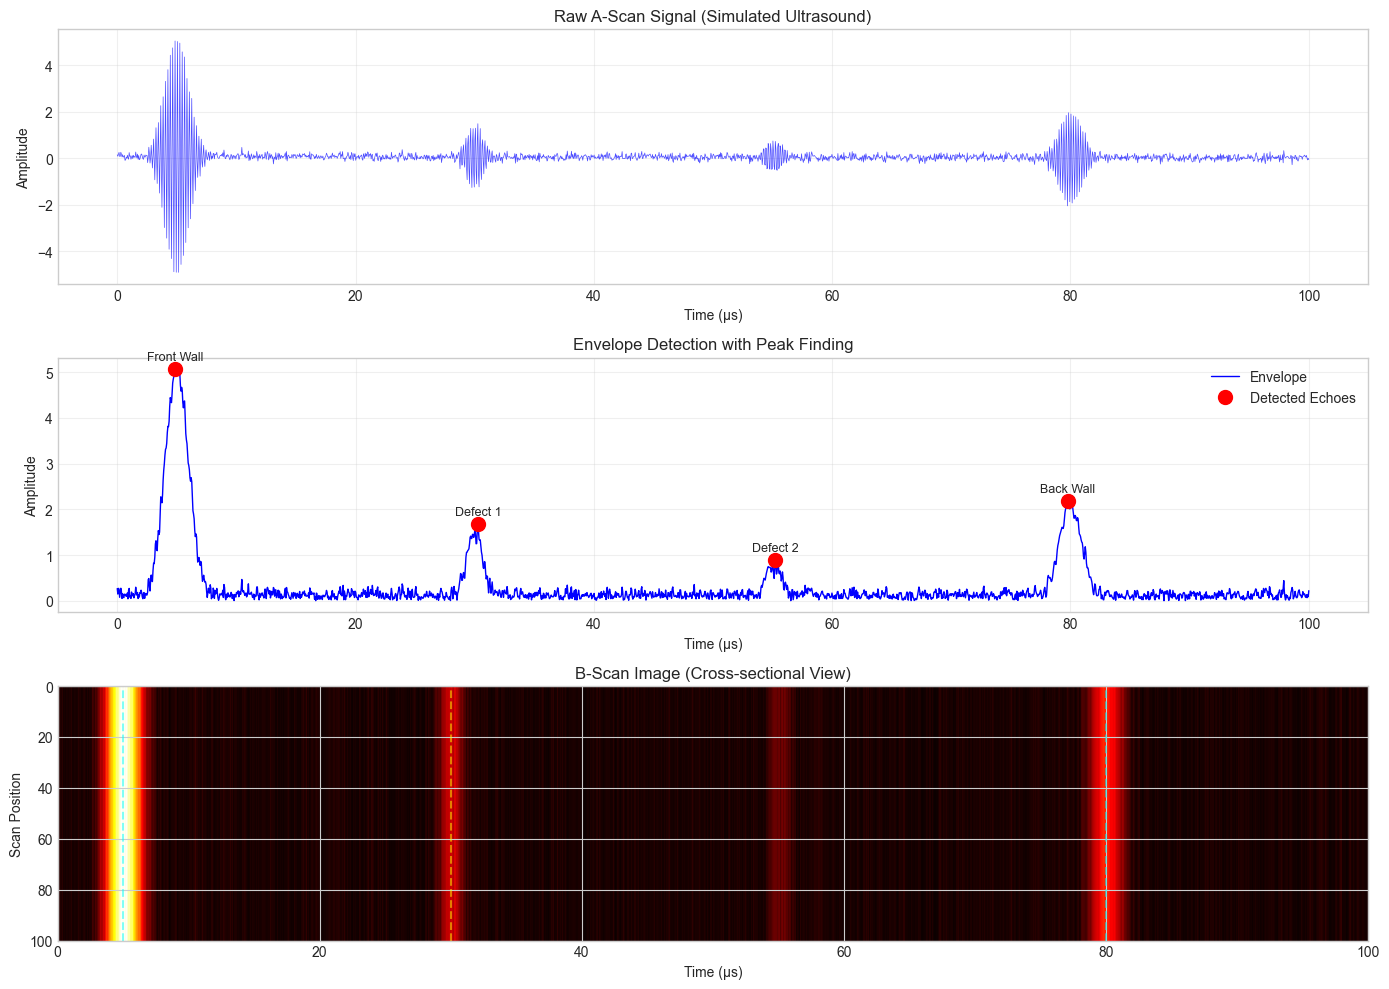


A-Scan Analysis Results:
  Echo 1: Time=4.9μs, Depth≈7.3mm, Amplitude=5.06
  Echo 2: Time=30.3μs, Depth≈45.4mm, Amplitude=1.68
  Echo 3: Time=55.2μs, Depth≈82.8mm, Amplitude=0.89
  Echo 4: Time=79.8μs, Depth≈119.7mm, Amplitude=2.17


In [11]:
def generate_synthetic_ascan():
    """Generate synthetic A-scan ultrasound signal with defects."""
    np.random.seed(42)

    # Time axis (microseconds)
    t = np.linspace(0, 100, 2000)

    # Base signal with attenuation
    signal = np.exp(-t / 50) * 0.1

    # Add initial pulse (front wall echo)
    front_wall = 5 * np.exp(-((t - 5)**2) / 2) * np.sin(2 * np.pi * 5 * t)

    # Add back wall echo
    back_wall = 2 * np.exp(-((t - 80)**2) / 2) * np.sin(2 * np.pi * 5 * t)

    # Add defect echoes
    defect1 = 1.5 * np.exp(-((t - 30)**2) / 1) * np.sin(2 * np.pi * 5 * t)
    defect2 = 0.8 * np.exp(-((t - 55)**2) / 1) * np.sin(2 * np.pi * 5 * t)

    # Combine and add noise
    signal = signal + front_wall + back_wall + defect1 + defect2
    signal += np.random.normal(0, 0.1, len(t))

    return t, signal


def analyze_ascan(t, signal):
    """Analyze A-scan signal for defect detection."""
    from scipy.signal import hilbert, find_peaks

    # Envelope detection using Hilbert transform
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)

    # Find peaks (potential defects)
    peaks, properties = find_peaks(envelope, height=0.5, distance=50)

    return envelope, peaks, properties


# Generate and analyze synthetic A-scan
t, ascan = generate_synthetic_ascan()
envelope, peaks, props = analyze_ascan(t, ascan)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Raw A-scan
axes[0].plot(t, ascan, 'b-', linewidth=0.5, alpha=0.7)
axes[0].set_xlabel('Time (μs)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Raw A-Scan Signal (Simulated Ultrasound)')
axes[0].grid(True, alpha=0.3)

# Envelope with peaks
axes[1].plot(t, envelope, 'b-', linewidth=1, label='Envelope')
axes[1].plot(t[peaks], envelope[peaks], 'ro', markersize=10, label='Detected Echoes')
axes[1].set_xlabel('Time (μs)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Envelope Detection with Peak Finding')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Annotate peaks
peak_labels = ['Front Wall', 'Defect 1', 'Defect 2', 'Back Wall']
for i, (peak, label) in enumerate(zip(peaks[:4], peak_labels)):
    axes[1].annotate(label, (t[peak], envelope[peak] + 0.2),
                     ha='center', fontsize=9)

# B-scan simulation
np.random.seed(123)
bscan = np.zeros((100, len(t)))
for i in range(100):
    # Vary defect positions slightly
    t_temp, sig = generate_synthetic_ascan()
    env, _, _ = analyze_ascan(t_temp, sig)
    bscan[i] = env

axes[2].imshow(bscan, aspect='auto', cmap='hot', extent=[0, 100, 100, 0])
axes[2].set_xlabel('Time (μs)')
axes[2].set_ylabel('Scan Position')
axes[2].set_title('B-Scan Image (Cross-sectional View)')
axes[2].axvline(x=5, color='cyan', linestyle='--', alpha=0.5, label='Front Wall')
axes[2].axvline(x=30, color='yellow', linestyle='--', alpha=0.5, label='Defect')
axes[2].axvline(x=80, color='cyan', linestyle='--', alpha=0.5, label='Back Wall')

plt.tight_layout()
plt.savefig(project_root / "outputs" / "industrial_ascan_analysis.png", dpi=150)
plt.show()

print("\nA-Scan Analysis Results:")
print("=" * 40)
for i, peak in enumerate(peaks[:4]):
    depth = t[peak] * 3000 / 2 / 1000  # Assuming 3000 m/s, convert to mm
    print(f"  Echo {i+1}: Time={t[peak]:.1f}μs, Depth≈{depth:.1f}mm, Amplitude={envelope[peak]:.2f}")

---
## 10. Summary

### Industrial Ultrasound Applications Demonstrated

| Application | Technique | Dataset/Demo |
|-------------|-----------|--------------|
| **Surface Defect Detection** | CNN Classification | Steel, Casting, NEU datasets |
| **A-Scan Analysis** | Envelope detection, Peak finding | Synthetic simulation |
| **B-Scan Imaging** | Cross-sectional visualization | Synthetic simulation |
| **Defect Characterization** | Signal processing | Time-of-flight analysis |

### Relevance to InPhase Solutions

This notebook demonstrates competencies directly applicable to InPhase's industrial work:

- **NDT/NDE**: Non-destructive testing signal analysis
- **Weld Inspection**: Defect detection in welded structures
- **Thickness Measurement**: Time-of-flight based depth estimation
- **AI for Inspection**: Deep learning for automated defect classification

### Available Industrial Datasets

1. **Severstal Steel Defect** - 12k+ images, 4 defect classes
2. **Casting Defect** - 7k+ images, binary classification
3. **NEU Surface Defect** - 1.8k images, 6 defect classes
4. **BUSI (Medical)** - 780 images, already processed

---

**Contact:** reza.mirzaeifard@gmail.com